# Forward Kinematics - 3-Joint Robot in 3D

This notebook introduces **forward kinematics** for a 3-joint robotic arm in 3D space.

Forward kinematics is the process of determining the position and orientation of the end-effector (robot's "hand") given the joint angles.

We will:
1. Understand rotation and transformation matrices
2. Implement Denavit-Hartenberg (DH) convention
3. Build a 3-joint robot model
4. Create interactive 3D visualizations
5. Experiment with different joint configurations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from IPython.display import display, HTML

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')


## Part 1: Basic Transformations

### Rotation Matrices

In 3D space, we can rotate around three axes: X, Y, and Z.

**Rotation around Z-axis** (used most commonly in planar robots):
$$ R_z(\theta) = \begin{bmatrix}
\cos\theta & -\sin\theta & 0 \\
\sin\theta & \cos\theta & 0 \\
0 & 0 & 1
\end{bmatrix} $$

**Rotation around Y-axis**:
$$ R_y(\theta) = \begin{bmatrix}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0 \\
-\sin\theta & 0 & \cos\theta
\end{bmatrix} $$

**Rotation around X-axis**:
$$ R_x(\theta) = \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos\theta & -\sin\theta \\
0 & \sin\theta & \cos\theta
\end{bmatrix} $$


In [2]:
def rotation_x(theta):
    """Rotation matrix around X-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c]
    ])

def rotation_y(theta):
    """Rotation matrix around Y-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, 0, s],
        [0, 1, 0],
        [-s, 0, c]
    ])

def rotation_z(theta):
    """Rotation matrix around Z-axis"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ])


### Homogeneous Transformation Matrices

To combine rotation and translation, we use **4x4 homogeneous transformation matrices**:

$$ T = \begin{bmatrix}
R_{3\times3} & t_{3\times1} \\
0_{1\times3} & 1
\end{bmatrix} $$

where $R$ is the rotation matrix and $t$ is the translation vector.


In [3]:
def homogeneous_transform(rotation_matrix, translation_vector):
    """
    Create a 4x4 homogeneous transformation matrix

    Parameters:
    rotation_matrix: 3x3 numpy array
    translation_vector: 3x1 numpy array or list [x, y, z]

    Returns:
    4x4 transformation matrix
    """
    T = np.eye(4)
    T[:3, :3] = rotation_matrix
    T[:3, 3] = translation_vector
    return T

# Example: Rotate 45° around Z and translate by [1, 2, 0]
theta = np.pi / 4  # 45 degrees
T_example = homogeneous_transform(rotation_z(theta), [1, 2, 0])
print("Example transformation matrix:")
print(T_example)


Example transformation matrix:
[[ 0.70710678 -0.70710678  0.          1.        ]
 [ 0.70710678  0.70710678  0.          2.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


## Part 2: Denavit-Hartenberg (DH) Convention

The DH convention is a systematic way to describe robot kinematics using 4 parameters per joint:

1. **θ (theta)**: Joint angle (rotation around $z_{i-1}$)
2. **d**: Link offset (translation along $z_{i-1}$)
3. **a**: Link length (translation along $x_i$)
4. **α (alpha)**: Link twist (rotation around $x_i$)

The DH transformation matrix from frame $i-1$ to frame $i$:

$$ T_i = \begin{bmatrix}
\cos\theta_i & -\sin\theta_i\cos\alpha_i & \sin\theta_i\sin\alpha_i & a_i\cos\theta_i \\
\sin\theta_i & \cos\theta_i\cos\alpha_i & -\cos\theta_i\sin\alpha_i & a_i\sin\theta_i \\
0 & \sin\alpha_i & \cos\alpha_i & d_i \\
0 & 0 & 0 & 1
\end{bmatrix} $$


In [4]:
def dh_transform(theta, d, a, alpha):
    """
    Create DH transformation matrix

    Parameters:
    theta: joint angle (radians)
    d: link offset along previous z
    a: link length along new x
    alpha: link twist around new x

    Returns:
    4x4 DH transformation matrix
    """
    ct, st = np.cos(theta), np.sin(theta)
    ca, sa = np.cos(alpha), np.sin(alpha)

    return np.array([
        [ct, -st*ca,  st*sa, a*ct],
        [st,  ct*ca, -ct*sa, a*st],
        [0,   sa,     ca,    d   ],
        [0,   0,      0,     1   ]
    ])


## Part 3: 3-Joint Robot Arm

Let's define a 3-joint robot arm with the following DH parameters:

| Joint | θ (variable) | d | a | α |
|-------|--------------|---|---|---|
| 1     | θ₁           | 0 | L₁ | 0 |
| 2     | θ₂           | 0 | L₂ | 0 |
| 3     | θ₃           | 0 | L₃ | 0 |

This represents a planar robot arm that can move in 3D space.


In [5]:
class Robot3DOF:
    """3 Degree-of-Freedom Robot Arm"""

    def __init__(self, L1=1.0, L2=1.0, L3=1.0):
        """
        Initialize robot with link lengths

        Parameters:
        L1, L2, L3: lengths of the three links
        """
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3

    def forward_kinematics(self, theta1, theta2, theta3):
        """
        Compute forward kinematics

        Parameters:
        theta1, theta2, theta3: joint angles in radians

        Returns:
        T_total: 4x4 transformation matrix from base to end-effector
        joint_positions: list of [x, y, z] positions for each joint
        """
        # DH parameters for each joint (theta, d, a, alpha)
        # For a planar robot in XY plane with rotation around Z
        T1 = dh_transform(theta1, 0, self.L1, 0)
        T2 = dh_transform(theta2, 0, self.L2, 0)
        T3 = dh_transform(theta3, 0, self.L3, 0)

        # Cumulative transformations
        T01 = T1
        T02 = T01 @ T2
        T03 = T02 @ T3

        # Extract positions of each joint
        base = np.array([0, 0, 0])
        joint1 = T01[:3, 3]
        joint2 = T02[:3, 3]
        end_effector = T03[:3, 3]

        joint_positions = [base, joint1, joint2, end_effector]

        return T03, joint_positions

    def get_transformation_matrices(self, theta1, theta2, theta3):
        """Get all intermediate transformation matrices"""
        T1 = dh_transform(theta1, 0, self.L1, 0)
        T2 = dh_transform(theta2, 0, self.L2, 0)
        T3 = dh_transform(theta3, 0, self.L3, 0)

        T01 = T1
        T02 = T01 @ T2
        T03 = T02 @ T3

        return [np.eye(4), T01, T02, T03]

# Create robot instance
robot = Robot3DOF(L1=1.0, L2=0.8, L3=0.6)


### Testing Forward Kinematics

Let's test with some example joint angles:


In [6]:
# Example 1: All joints at 0°
theta1, theta2, theta3 = 0, 0, 0
T, positions = robot.forward_kinematics(theta1, theta2, theta3)

print("Joint angles: [0°, 0°, 0°]")
print("\nEnd-effector position:", positions[-1])
print("\nFull transformation matrix:")
print(T)


Joint angles: [0°, 0°, 0°]

End-effector position: [2.4 0.  0. ]

Full transformation matrix:
[[1.  0.  0.  2.4]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]


In [7]:
# Example 2: First joint at 45°
theta1, theta2, theta3 = np.pi/4, 0, 0
T, positions = robot.forward_kinematics(theta1, theta2, theta3)

print("Joint angles: [45°, 0°, 0°]")
print("End-effector position:", positions[-1])


Joint angles: [45°, 0°, 0°]
End-effector position: [1.69705627 1.69705627 0.        ]


In [8]:
# Example 3: All joints at 30°
theta1, theta2, theta3 = np.pi/6, np.pi/6, np.pi/6
T, positions = robot.forward_kinematics(theta1, theta2, theta3)

print("Joint angles: [30°, 30°, 30°]")
print("End-effector position:", positions[-1])


Joint angles: [30°, 30°, 30°]
End-effector position: [1.2660254  1.79282032 0.        ]


## Part 4: 3D Visualization

Let's create functions to visualize our robot in 3D space.


C:\Users\milos\AppData\Local\Temp\ipykernel_22364\752349899.py:83: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\752349899.py:83: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\752349899.py:83: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\milos\miniconda3\envs\RoboticsExercises\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\milos\miniconda3\envs\RoboticsExercises\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\milos\miniconda3\envs\RoboticsExercises\Lib\site-packages\IPython\core\pylabtools.p

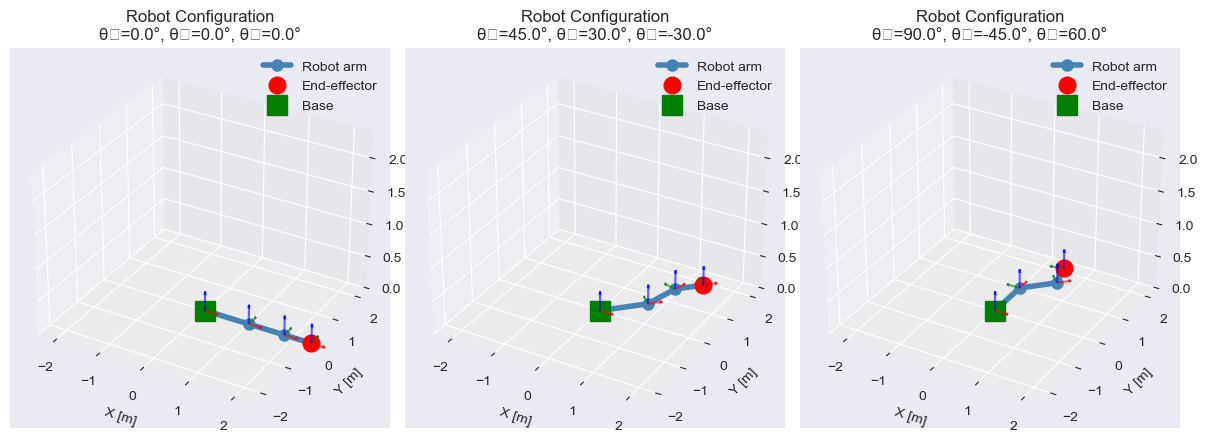

In [9]:
def plot_robot_3d(robot, theta1, theta2, theta3, ax=None, show_frames=True):
    """
    Plot robot configuration in 3D

    Parameters:
    robot: Robot3DOF instance
    theta1, theta2, theta3: joint angles in radians
    ax: matplotlib 3D axis (creates new if None)
    show_frames: whether to show coordinate frames
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Compute forward kinematics
    T, positions = robot.forward_kinematics(theta1, theta2, theta3)

    # Extract x, y, z coordinates
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]
    zs = [p[2] for p in positions]

    # Plot robot links
    ax.plot(xs, ys, zs, 'o-', linewidth=4, markersize=8,
            color='steelblue', label='Robot arm')

    # Highlight end-effector
    ax.plot([xs[-1]], [ys[-1]], [zs[-1]], 'o', markersize=12,
            color='red', label='End-effector')

    # Plot base
    ax.plot([xs[0]], [ys[0]], [zs[0]], 's', markersize=15,
            color='green', label='Base')

    # Show coordinate frames
    if show_frames:
        transforms = robot.get_transformation_matrices(theta1, theta2, theta3)
        frame_length = 0.3

        for i, T in enumerate(transforms):
            origin = T[:3, 3]
            x_axis = T[:3, 0] * frame_length
            y_axis = T[:3, 1] * frame_length
            z_axis = T[:3, 2] * frame_length

            # X-axis (red), Y-axis (green), Z-axis (blue)
            ax.quiver(*origin, *x_axis, color='r', alpha=0.6, arrow_length_ratio=0.2)
            ax.quiver(*origin, *y_axis, color='g', alpha=0.6, arrow_length_ratio=0.2)
            ax.quiver(*origin, *z_axis, color='b', alpha=0.6, arrow_length_ratio=0.2)

    # Set labels and limits
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')

    # Set equal aspect ratio
    max_range = robot.L1 + robot.L2 + robot.L3
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([0, max_range])

    ax.set_title(f'Robot Configuration\nθ₁={np.degrees(theta1):.1f}°, '
                 f'θ₂={np.degrees(theta2):.1f}°, θ₃={np.degrees(theta3):.1f}°')
    ax.legend()

    return ax

# Test visualization
fig = plt.figure(figsize=(12, 5))

# Configuration 1
ax1 = fig.add_subplot(131, projection='3d')
plot_robot_3d(robot, 0, 0, 0, ax=ax1)

# Configuration 2
ax2 = fig.add_subplot(132, projection='3d')
plot_robot_3d(robot, np.pi/4, np.pi/6, -np.pi/6, ax=ax2)

# Configuration 3
ax3 = fig.add_subplot(133, projection='3d')
plot_robot_3d(robot, np.pi/2, -np.pi/4, np.pi/3, ax=ax3)

plt.tight_layout()
plt.show()


## Part 5: Interactive Visualization with Sliders

Now let's create an interactive plot where you can control the joint angles with sliders!


C:\Users\milos\AppData\Local\Temp\ipykernel_22364\1725254524.py:18: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  slider_theta1 = Slider(ax_theta1, 'θ₁ [deg]', -180, 180,
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\1725254524.py:20: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  slider_theta2 = Slider(ax_theta2, 'θ₂ [deg]', -180, 180,
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\1725254524.py:20: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  slider_theta2 = Slider(ax_theta2, 'θ₂ [deg]', -180, 180,
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\1725254524.py:22: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  slider_theta3 = Slider(ax_theta3, 'θ₃ [deg]', -180, 180,
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\1725254524.py:22: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  slider_theta3 = Slider(ax_theta3, 'θ₃ [deg]', -180, 180,
C:\Us

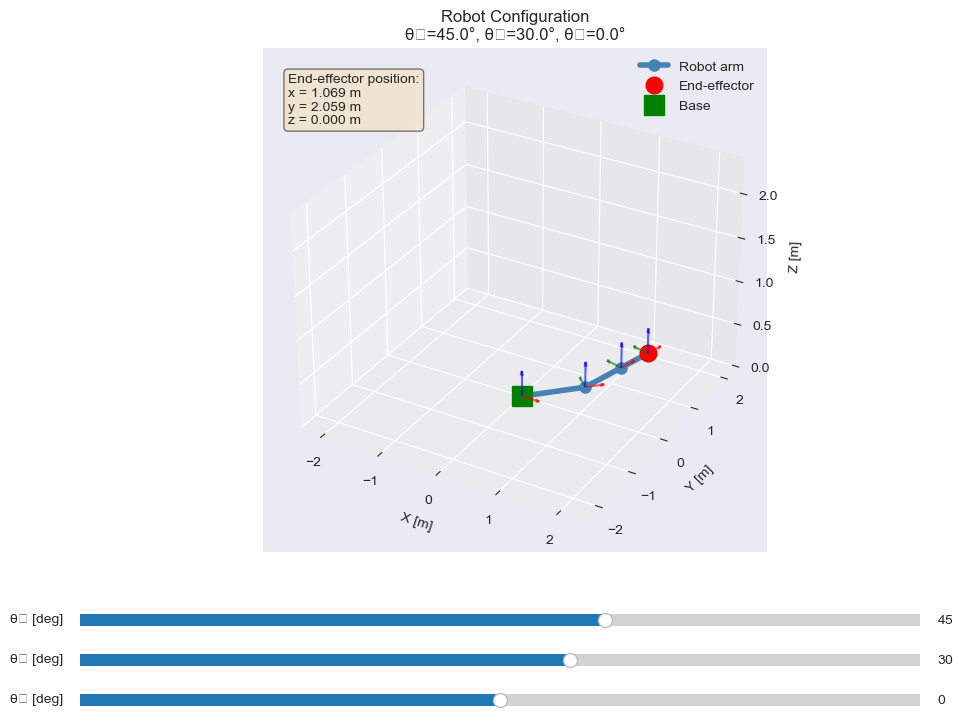

In [10]:
def create_interactive_robot():
    """Create interactive robot visualization with sliders"""

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(bottom=0.25)

    # Initial joint angles
    theta1_init = np.pi / 4
    theta2_init = np.pi / 6
    theta3_init = 0

    # Create sliders
    ax_theta1 = plt.axes([0.15, 0.15, 0.7, 0.03])
    ax_theta2 = plt.axes([0.15, 0.10, 0.7, 0.03])
    ax_theta3 = plt.axes([0.15, 0.05, 0.7, 0.03])

    slider_theta1 = Slider(ax_theta1, 'θ₁ [deg]', -180, 180,
                           valinit=np.degrees(theta1_init))
    slider_theta2 = Slider(ax_theta2, 'θ₂ [deg]', -180, 180,
                           valinit=np.degrees(theta2_init))
    slider_theta3 = Slider(ax_theta3, 'θ₃ [deg]', -180, 180,
                           valinit=np.degrees(theta3_init))

    def update(val):
        ax.cla()
        theta1 = np.radians(slider_theta1.val)
        theta2 = np.radians(slider_theta2.val)
        theta3 = np.radians(slider_theta3.val)

        plot_robot_3d(robot, theta1, theta2, theta3, ax=ax)

        # Display end-effector position
        T, positions = robot.forward_kinematics(theta1, theta2, theta3)
        end_pos = positions[-1]
        ax.text2D(0.05, 0.95, f'End-effector position:\n'
                               f'x = {end_pos[0]:.3f} m\n'
                               f'y = {end_pos[1]:.3f} m\n'
                               f'z = {end_pos[2]:.3f} m',
                  transform=ax.transAxes, fontsize=10,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        fig.canvas.draw_idle()

    # Connect sliders to update function
    slider_theta1.on_changed(update)
    slider_theta2.on_changed(update)
    slider_theta3.on_changed(update)

    # Initial plot
    update(None)

    plt.show()

# Create interactive plot
create_interactive_robot()


## Part 6: Workspace Analysis

The **workspace** of a robot is the set of all positions that the end-effector can reach.

Let's visualize the workspace by sampling many random configurations:


Workspace Statistics:
  Maximum reach: 2.400 m
  Minimum reach: 0.013 m
  X range: [-2.387, 2.372] m
  Y range: [-2.392, 2.398] m
  Z range: [0.000, 0.000] m


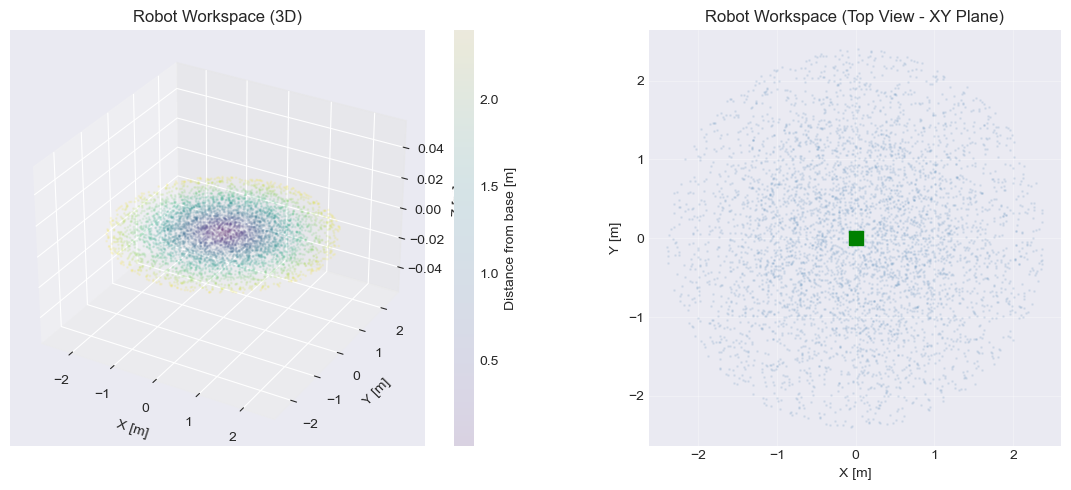

In [11]:
def plot_workspace(robot, num_samples=5000):
    """
    Visualize robot workspace by random sampling

    Parameters:
    robot: Robot3DOF instance
    num_samples: number of random configurations to sample
    """
    # Generate random joint angles
    theta1_samples = np.random.uniform(-np.pi, np.pi, num_samples)
    theta2_samples = np.random.uniform(-np.pi, np.pi, num_samples)
    theta3_samples = np.random.uniform(-np.pi, np.pi, num_samples)

    # Compute end-effector positions
    positions = []
    for t1, t2, t3 in zip(theta1_samples, theta2_samples, theta3_samples):
        _, joint_pos = robot.forward_kinematics(t1, t2, t3)
        positions.append(joint_pos[-1])

    positions = np.array(positions)

    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 5))

    # 3D view
    ax1 = fig.add_subplot(121, projection='3d')
    scatter = ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
                         c=np.sqrt(positions[:, 0]**2 + positions[:, 1]**2 + positions[:, 2]**2),
                         cmap='viridis', alpha=0.1, s=1)
    ax1.set_xlabel('X [m]')
    ax1.set_ylabel('Y [m]')
    ax1.set_zlabel('Z [m]')
    ax1.set_title('Robot Workspace (3D)')
    plt.colorbar(scatter, ax=ax1, label='Distance from base [m]')

    # Top view (XY plane)
    ax2 = fig.add_subplot(122)
    ax2.scatter(positions[:, 0], positions[:, 1], alpha=0.1, s=1, c='steelblue')
    ax2.set_xlabel('X [m]')
    ax2.set_ylabel('Y [m]')
    ax2.set_title('Robot Workspace (Top View - XY Plane)')
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)

    # Add robot base
    ax2.plot(0, 0, 's', markersize=10, color='green', label='Base')

    # Calculate and display workspace statistics
    max_reach = np.max(np.sqrt(positions[:, 0]**2 + positions[:, 1]**2 + positions[:, 2]**2))
    min_reach = np.min(np.sqrt(positions[:, 0]**2 + positions[:, 1]**2 + positions[:, 2]**2))

    print(f"Workspace Statistics:")
    print(f"  Maximum reach: {max_reach:.3f} m")
    print(f"  Minimum reach: {min_reach:.3f} m")
    print(f"  X range: [{positions[:, 0].min():.3f}, {positions[:, 0].max():.3f}] m")
    print(f"  Y range: [{positions[:, 1].min():.3f}, {positions[:, 1].max():.3f}] m")
    print(f"  Z range: [{positions[:, 2].min():.3f}, {positions[:, 2].max():.3f}] m")

    plt.tight_layout()
    plt.show()

# Visualize workspace
plot_workspace(robot, num_samples=5000)


## Part 7: Trajectory Planning

Let's create a simple trajectory for the end-effector to follow:


C:\Users\milos\AppData\Local\Temp\ipykernel_22364\2910707282.py:71: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\2910707282.py:71: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\milos\AppData\Local\Temp\ipykernel_22364\2910707282.py:71: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()


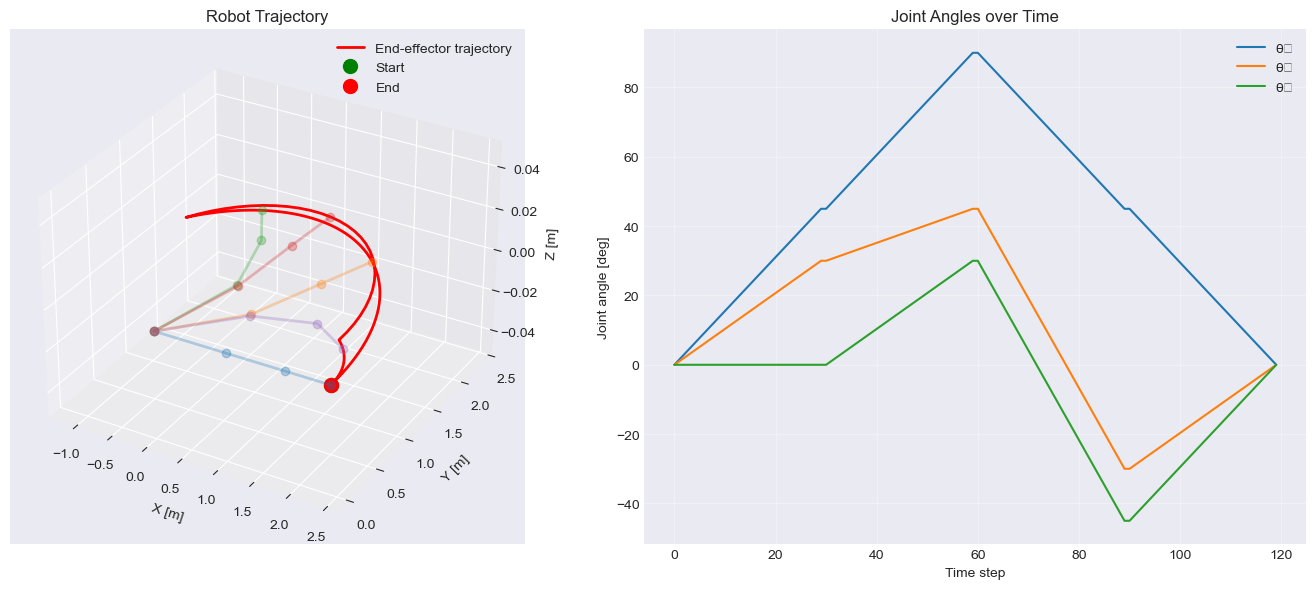

In [12]:
def animate_trajectory(robot, waypoints, num_steps=50):
    """
    Animate robot following a trajectory (note: this uses forward kinematics only,
    inverse kinematics would be needed for true trajectory planning)

    Parameters:
    robot: Robot3DOF instance
    waypoints: list of (theta1, theta2, theta3) tuples
    num_steps: interpolation steps between waypoints
    """
    fig = plt.figure(figsize=(14, 6))

    # 3D view
    ax1 = fig.add_subplot(121, projection='3d')

    # Joint angles over time
    ax2 = fig.add_subplot(122)

    all_configurations = []
    all_positions = []

    # Interpolate between waypoints
    for i in range(len(waypoints) - 1):
        start = np.array(waypoints[i])
        end = np.array(waypoints[i + 1])

        for t in np.linspace(0, 1, num_steps):
            config = start + t * (end - start)
            all_configurations.append(config)

            _, positions = robot.forward_kinematics(*config)
            all_positions.append(positions[-1])

    all_configurations = np.array(all_configurations)
    all_positions = np.array(all_positions)

    # Plot trajectory in 3D
    ax1.plot(all_positions[:, 0], all_positions[:, 1], all_positions[:, 2],
             'r-', linewidth=2, label='End-effector trajectory')
    ax1.plot(all_positions[0, 0], all_positions[0, 1], all_positions[0, 2],
             'go', markersize=10, label='Start')
    ax1.plot(all_positions[-1, 0], all_positions[-1, 1], all_positions[-1, 2],
             'ro', markersize=10, label='End')

    # Plot robot at several positions
    for idx in range(0, len(all_configurations), len(all_configurations)//5):
        config = all_configurations[idx]
        _, positions = robot.forward_kinematics(*config)
        xs = [p[0] for p in positions]
        ys = [p[1] for p in positions]
        zs = [p[2] for p in positions]
        ax1.plot(xs, ys, zs, 'o-', alpha=0.3, linewidth=2)

    ax1.set_xlabel('X [m]')
    ax1.set_ylabel('Y [m]')
    ax1.set_zlabel('Z [m]')
    ax1.set_title('Robot Trajectory')
    ax1.legend()

    # Plot joint angles over time
    time = np.arange(len(all_configurations))
    ax2.plot(time, np.degrees(all_configurations[:, 0]), label='θ₁')
    ax2.plot(time, np.degrees(all_configurations[:, 1]), label='θ₂')
    ax2.plot(time, np.degrees(all_configurations[:, 2]), label='θ₃')
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Joint angle [deg]')
    ax2.set_title('Joint Angles over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Define waypoints (joint angles in radians)
waypoints = [
    (0, 0, 0),
    (np.pi/4, np.pi/6, 0),
    (np.pi/2, np.pi/4, np.pi/6),
    (np.pi/4, -np.pi/6, -np.pi/4),
    (0, 0, 0)
]

animate_trajectory(robot, waypoints, num_steps=30)


## Part 8: Exercises

### Exercise 1: Reachability Test
Test if the robot can reach the point (1.5, 1.5, 0) with the current link lengths.


Best configuration found: θ₁=44.2°, θ₂=30.5°, θ₃=-71.5°
Distance to target: 0.0268 m


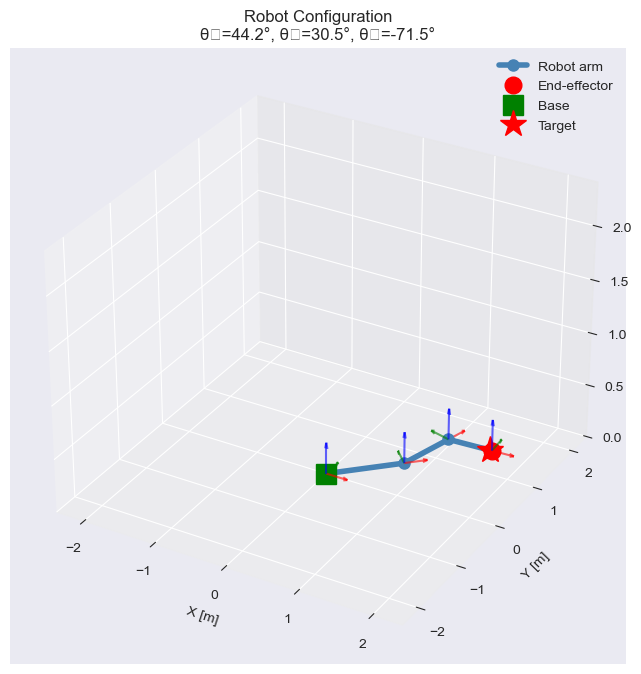

In [13]:
#################################################################
# YOUR CODE HERE

target_point = np.array([1.5, 1.5, 0])

# Try different joint angles to reach the target
# Hint: You need inverse kinematics for precise solution,
# but you can try manual tuning or random search

def find_configuration(robot, target, num_attempts=10000):
    """Try to find a configuration that reaches close to target"""
    best_config = None
    best_distance = float('inf')

    for _ in range(num_attempts):
        # Random joint angles
        theta1 = np.random.uniform(-np.pi, np.pi)
        theta2 = np.random.uniform(-np.pi, np.pi)
        theta3 = np.random.uniform(-np.pi, np.pi)

        _, positions = robot.forward_kinematics(theta1, theta2, theta3)
        end_pos = positions[-1]

        distance = np.linalg.norm(end_pos - target)

        if distance < best_distance:
            best_distance = distance
            best_config = (theta1, theta2, theta3)

    return best_config, best_distance

config, distance = find_configuration(robot, target_point)
print(f"Best configuration found: θ₁={np.degrees(config[0]):.1f}°, "
      f"θ₂={np.degrees(config[1]):.1f}°, θ₃={np.degrees(config[2]):.1f}°")
print(f"Distance to target: {distance:.4f} m")

# Visualize result
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_robot_3d(robot, *config, ax=ax)
ax.plot([target_point[0]], [target_point[1]], [target_point[2]],
        'r*', markersize=20, label='Target')
ax.legend()
plt.show()

#################################################################


### Exercise 2: Custom Robot
Create a robot with different link lengths and explore its workspace.


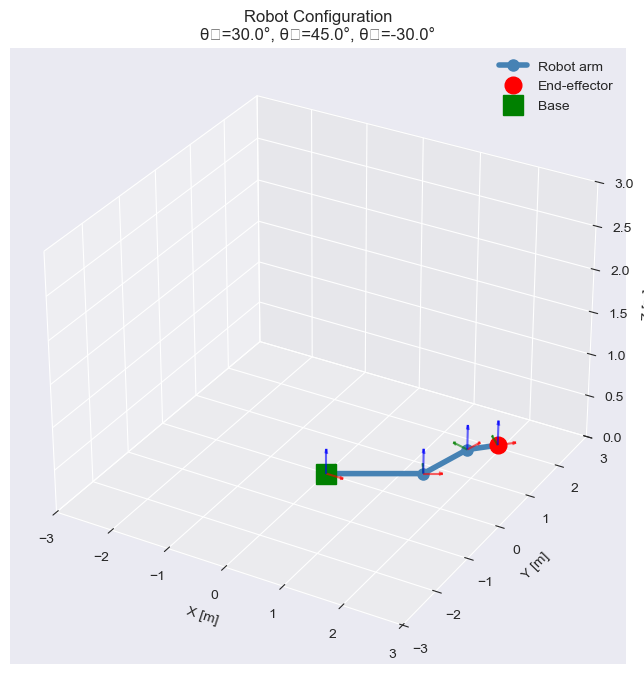

Workspace Statistics:
  Maximum reach: 3.000 m
  Minimum reach: 0.009 m
  X range: [-2.994, 2.985] m
  Y range: [-2.983, 2.993] m
  Z range: [0.000, 0.000] m


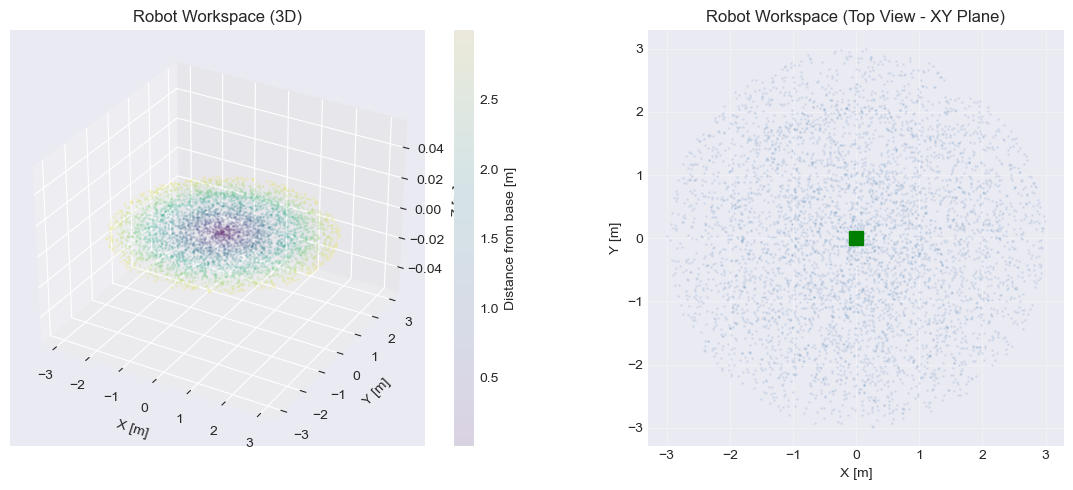

In [14]:
#################################################################
# YOUR CODE HERE

# Create your own robot with custom link lengths
my_robot = Robot3DOF(L1=1.5, L2=1.0, L3=0.5)

# Visualize it
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_robot_3d(my_robot, np.pi/6, np.pi/4, -np.pi/6, ax=ax)
plt.show()

# Analyze workspace
plot_workspace(my_robot, num_samples=5000)

#################################################################


### Exercise 3: Jacobian Matrix (Advanced)

The Jacobian matrix relates joint velocities to end-effector velocities:

$$ \dot{\mathbf{x}} = J(\boldsymbol{\theta}) \dot{\boldsymbol{\theta}} $$

Implement numerical Jacobian computation:


In [15]:
def compute_jacobian_numerical(robot, theta1, theta2, theta3, delta=1e-6):
    """
    Compute Jacobian matrix numerically using finite differences

    Returns:
    J: 3x3 Jacobian matrix (position only)
    """
    #################################################################
    # YOUR CODE HERE

    # Get current end-effector position
    _, positions = robot.forward_kinematics(theta1, theta2, theta3)
    pos_current = positions[-1]

    # Initialize Jacobian
    J = np.zeros((3, 3))

    # Compute partial derivatives numerically
    # ∂x/∂θ₁
    _, positions_1 = robot.forward_kinematics(theta1 + delta, theta2, theta3)
    J[:, 0] = (positions_1[-1] - pos_current) / delta

    # ∂x/∂θ₂
    _, positions_2 = robot.forward_kinematics(theta1, theta2 + delta, theta3)
    J[:, 1] = (positions_2[-1] - pos_current) / delta

    # ∂x/∂θ₃
    _, positions_3 = robot.forward_kinematics(theta1, theta2, theta3 + delta)
    J[:, 2] = (positions_3[-1] - pos_current) / delta

    #################################################################

    return J

# Test Jacobian
theta1, theta2, theta3 = np.pi/4, np.pi/6, 0
J = compute_jacobian_numerical(robot, theta1, theta2, theta3)

print("Jacobian matrix at configuration [45°, 30°, 0°]:")
print(J)
print("\nJacobian determinant:", np.linalg.det(J))
print("(Determinant close to 0 indicates singularity)")


Jacobian matrix at configuration [45°, 30°, 0°]:
[[-2.05940347 -1.35229634 -0.57955557]
 [ 1.06945241  0.36234599  0.15529114]
 [ 0.          0.          0.        ]]

Jacobian determinant: 0.0
(Determinant close to 0 indicates singularity)


## Summary

In this notebook, you learned:

1. **Basic transformations**: Rotation matrices and homogeneous transforms
2. **DH Convention**: Systematic way to describe robot kinematics
3. **Forward Kinematics**: Computing end-effector pose from joint angles
4. **3D Visualization**: Plotting robot configurations in 3D space
5. **Workspace Analysis**: Understanding reachable positions
6. **Trajectory Planning**: Moving the robot through waypoints
7. **Jacobian Matrix**: Relating joint and end-effector velocities

### Next Steps:
- Learn **inverse kinematics** to find joint angles for desired end-effector positions
- Study **velocity kinematics** and the Jacobian in depth
- Explore **dynamics** and how forces affect robot motion
- Implement **path planning** algorithms
- Study different robot configurations (SCARA, 6-DOF arms, etc.)

### References:
- Craig, J.J. "Introduction to Robotics: Mechanics and Control"
- Spong, M.W., Hutchinson, S., Vidyasagar, M. "Robot Modeling and Control"
- [Modern Robotics textbook](http://hades.mech.northwestern.edu/index.php/Modern_Robotics)
